# 1. Konfiguracja środowiska i import danych sprzedażowych Walmart

Zainicjowano projekt regresyjny, przygotowując środowisko do zaawansowanej analizy predykcyjnej. Zaimportowano szeroki zestaw narzędzi: od standardowych bibliotek do przetwarzania danych (`pandas`, `numpy`) i wizualizacji (`seaborn`), po zaawansowane moduły uczenia maszynowego (`scikit-learn`) oraz głębokiego (`TensorFlow/Keras`). Architektura rozwiązania przewiduje porównanie różnych podejść, w tym regresji MLP, sieci konwolucyjnych (CNN) oraz sieci rekurencyjnych (RNN/LSTM). Korzystając z biblioteki `kagglehub`, pobrano zbiór danych "Walmart Sales", który zawiera historyczne informacje o sprzedaży tygodniowej w zestawieniu z czynnikami ekonomicznymi i pogodowymi. Proces kończy się wczytaniem głównego pliku CSV i weryfikacją rozmiaru ramki danych, co stanowi fundament pod dalsze modelowanie szeregów czasowych.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Importy do CNN, RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from tensorflow.keras.optimizers import Adam

# @title Download Dataset
dataset_slug = "mikhail1681/walmart-sales"
path = kagglehub.dataset_download(dataset_slug)

csv_files = glob.glob(os.path.join(path, "*.csv"))
if len(csv_files) == 0:
    raise FileNotFoundError(f"No CSV files found in: {path}")

walmart_data = pd.read_csv(csv_files[0])
print(f"Loaded dataset shape: {walmart_data.shape}")

100%|██████████| 122k/122k [00:00<00:00, 41.9MB/s]

Extracting files...
Loaded dataset shape: (6435, 8)


# 2. Przetwarzanie danych i inżynieria cech czasowych

Przeprowadzono transformację surowych danych sprzedażowych w ustrukturyzowany zbiór cech przystosowany do analizy szeregów czasowych. Pierwszym kluczowym krokiem była konwersja kolumny daty na format obiektowy oraz chronologiczne posortowanie całego zbioru, co jest niezbędne dla zachowania zależności czasowych w modelach regresyjnych. Następnie, za pomocą inżynierii cech, wyodrębniono składowe daty takie jak rok, miesiąc, tydzień oraz dzień, a także przekształcono flagę świąteczną na format binarny. Operacje te pozwalają modelowi lepiej zrozumieć sezonowość sprzedaży oraz trendy roczne, jednocześnie usuwając pierwotne znaczniki czasu, które nie mogłyby zostać bezpośrednio przetworzone przez algorytmy uczenia maszynowego.

In [2]:
# @title Preprocessing & Feature Engineering
data_processed = walmart_data.copy()

# Konwersja daty
data_processed['Date'] = pd.to_datetime(data_processed['Date'], format='%d-%m-%Y')

# WYMÓG: Szereg czasowy wymaga posortowania danych
data_processed = data_processed.sort_values(by='Date').reset_index(drop=True)

# Ekstrakcja cech
data_processed = data_processed.assign(
    Year = lambda x: x['Date'].dt.year,
    Month = lambda x: x['Date'].dt.month,
    Week = lambda x: x['Date'].dt.isocalendar().week.astype(int),
    Day = lambda x: x['Date'].dt.day,
    IsHoliday = lambda x: x['Holiday_Flag'].astype(int)
).drop(columns=['Date', 'Holiday_Flag']) # Usuwamy oryginalną datę

print("Data sorted chronologically.")
data_processed.head()

Data sorted chronologically.


,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,IsHoliday
0,1,1643690.90,42.31,2.572,211.096358,8.106,2010,2,5,5,0
1,10,2193048.75,54.34,2.962,126.442065,9.765,2010,2,5,5,0
2,37,536006.73,45.97,2.572,209.852966,8.554,2010,2,5,5,0
3,17,789036.02,23.11,2.666,126.442065,6.548,2010,2,5,5,0
4,30,465108.52,39.05,2.572,210.752605,8.324,2010,2,5,5,0


# 3. Eksploracyjna analiza danych (EDA)

Przeprowadzono analizę statystyczną zmiennej celu oraz wzajemnych powiązań między cechami numerycznymi. Za pomocą histogramu z nałożoną krzywą gęstości (KDE) zweryfikowano rozkład tygodniowej sprzedaży, co pozwoliło na ocenę jej skośności i identyfikację wartości nietypowych. Równocześnie wygenerowano macierz korelacji w formie mapy ciepła, która zobrazowała siłę i kierunek zależności między wskaźnikami ekonomicznymi, takimi jak temperatura, cena paliwa czy stopa bezrobocia, a wolumenem sprzedaży. Taka inspekcja wizualna jest kluczowa dla zrozumienia dynamiki danych oraz wstępnej selekcji zmiennych, które w największym stopniu wpływają na prognozowany wynik finansowy.

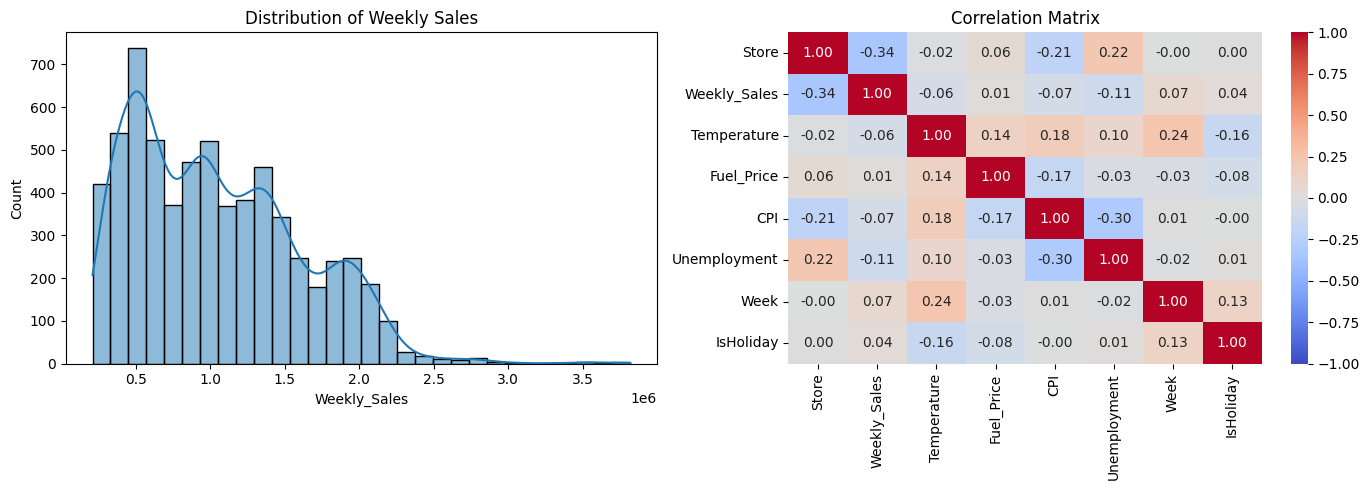

In [3]:
# @title EDA - Target Distribution & Correlation
plt.figure(figsize=(14, 5))

# Rozkład zmiennej celu
plt.subplot(1, 2, 1)
sns.histplot(data_processed['Weekly_Sales'], bins=30, kde=True)
plt.title('Distribution of Weekly Sales')

# Heatmapa korelacji
plt.subplot(1, 2, 2)
numeric_df = data_processed.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

# 4. Chronologiczny podział danych na zbiory

Przygotowano dane do procesu modelowania, stosując sztywny podział chronologiczny zamiast losowego losowania próbek. Ze względu na charakter szeregów czasowych, zbiór został podzielony na trzy części za pomocą indeksowania (slicing): treningową (pierwsze 70% danych), walidacyjną (kolejne 15%) oraz testową (ostatnie 15%). Taka strategia podziału pozwala na rzetelną ocenę zdolności prognostycznych modeli na danych „przyszłych”, których algorytm nie widział w trakcie nauki, eliminując ryzyko wycieku informacji (data leakage) i tzw. look-ahead bias. Wyodrębniono przy tym macierz cech oraz wektor zmiennej celu, zapewniając gotowość zbiorów do procesów standaryzacji i treningu.

In [4]:
# @title Chronological Train-Val-Test Split
X = data_processed.drop(columns=['Weekly_Sales'])
y = data_processed['Weekly_Sales'].values.reshape(-1, 1)

# Ustalenie punktów podziału (70% - 15% - 15%)
n = len(data_processed)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Podział chronologiczny (slicing)
X_train_raw = X.iloc[:train_end]
X_val_raw = X.iloc[train_end:val_end]
X_test_raw = X.iloc[val_end:]

y_train_raw = y[:train_end]
y_val_raw = y[train_end:val_end]
y_test_raw = y[val_end:]

print(f"Train set: {X_train_raw.shape} (First 70%)")
print(f"Val set:   {X_val_raw.shape} (Next 15%)")
print(f"Test set:  {X_test_raw.shape} (Last 15%)")

Train set: (4504, 10) (First 70%)
Val set:   (965, 10) (Next 15%)
Test set:  (966, 10) (Last 15%)


# 5. Potok przetwarzania i skalowanie danych

Zaprojektowano i wdrożono potok przetwarzania danych, który automatyzuje czyszczenie oraz normalizację cech wejściowych. Wykorzystano obiekt Pipeline do uzupełnienia brakujących wartości medianą oraz ujednolicenia skali wszystkich zmiennych numerycznych za pomocą StandardScaler. Kluczowym elementem tego etapu jest również oddzielne skalowanie zmiennej celu (Weekly_Sales), co jest niezbędne dla poprawnego działania sieci neuronowych operujących na danych o dużej rozpiętości wartości. Wszystkie transformatory zostały dopasowane wyłącznie do zbioru treningowego, a następnie zaaplikowane do zbiorów walidacyjnego i testowego, co zapobiega wyciekowi informacji i zapewnia rzetelność wyników. Całość przygotowań domyka definicja bazowego modelu MLPRegressor, który posłuży jako fundament do dalszych porównań z autorskimi rozwiązaniami.

In [5]:
# @title Pipeline Setup (Preprocessing)

# Preprocessor dla X
numeric_features = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day', 'IsHoliday']
# Zakładamy brak zmiennych tekstowych po preprocessing, wszystko numeryczne

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Skaler dla Y (niezbędny dla sieci neuronowych przy dużych wartościach Sales)
target_scaler = StandardScaler()

# Fitowanie na zbiorze TRENINGOWYM
X_train = preprocessor.fit_transform(X_train_raw)
X_val = preprocessor.transform(X_val_raw)
X_test = preprocessor.transform(X_test_raw)

y_train = target_scaler.fit_transform(y_train_raw)
y_val = target_scaler.transform(y_val_raw)
y_test = target_scaler.transform(y_test_raw)

# Definicja bibliotecznego MLP (będzie użyty w pętli eksperymentów)
def build_sklearn_mlp(random_seed=None):
    return MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=random_seed)

# 6. Autorska implementacja regresora sieciowego w NumPy

Zbudowano dedykowaną klasę `CustomNumpyNNRegressor`, która implementuje pełną architekturę sieci neuronowej do zadań regresji przy użyciu wyłącznie biblioteki NumPy. Model wykorzystuje algorytm wstecznej propagacji błędu (Backpropagation) oraz optymalizację typu Momentum, co pozwala na stabilniejszą i szybszą minimalizację funkcji błędu średniokwadratowego (MSE). W celu zapewnienia optymalnego startu procesu uczenia, wagi są inicjalizowane metodą Xaviera (Glorot), która dostosowuje ich rozpiętość do liczby wejść i wyjść warstwy.

Architektura sieci opiera się na funkcjach aktywacji sigmoid w warstwach ukrytych oraz wyjściu liniowym, co jest kluczowe dla przewidywania ciągłych wartości sprzedaży. Dzięki zgodności z interfejsem BaseEstimator, model jest w pełni kompatybilny z ekosystemem Scikit-learn, co pozwala na jego łatwe trenowanie i testowanie w ramach standardowych procedur ewaluacyjnych.

In [6]:
# @title Custom Numpy Neural Network (Regressor)
class CustomNumpyNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_sizes=(64,), learning_rate=0.01,
                 epochs=100, momentum=0.9, random_seed=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.momentum = momentum
        self.random_seed = random_seed

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _sigmoid_derivative(self, a):
        return a * (1 - a)

    def _initialize_weights(self, n_features):
        if self.random_seed: np.random.seed(self.random_seed)
        layer_sizes = [n_features] + list(self.hidden_layer_sizes) + [1]
        self.weights_, self.biases_ = [], []
        self.v_weights_, self.v_biases_ = [], []

        for i in range(len(layer_sizes) - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            W = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights_.append(W); self.biases_.append(b)
            self.v_weights_.append(np.zeros_like(W)); self.v_biases_.append(np.zeros_like(b))

    def _forward(self, X):
        self.As_ = [X]
        curr = X
        for i in range(len(self.weights_) - 1): # Hidden
            Z = np.dot(curr, self.weights_[i]) + self.biases_[i]
            A = self._sigmoid(Z)
            self.As_.append(A); curr = A
        # Output (Linear for Regression)
        last = len(self.weights_) - 1
        A_final = np.dot(curr, self.weights_[last]) + self.biases_[last]
        self.As_.append(A_final)
        return A_final

    def fit(self, X, y):
        X, y = check_X_y(X, y); y = y.reshape(-1, 1)
        self._initialize_weights(X.shape[1])
        m = X.shape[0]
        for _ in range(self.epochs):
            A_final = self._forward(X)
            dZ = A_final - y # Derivative of MSE with Linear output
            for i in range(len(self.weights_)-1, -1, -1):
                A_prev = self.As_[i]
                dW = (1/m)*np.dot(A_prev.T, dZ)
                db = (1/m)*np.sum(dZ, axis=0, keepdims=True)
                # Momentum
                self.v_weights_[i] = self.momentum*self.v_weights_[i] - self.learning_rate*dW
                self.v_biases_[i] = self.momentum*self.v_biases_[i] - self.learning_rate*db
                self.weights_[i] += self.v_weights_[i]
                self.biases_[i] += self.v_biases_[i]
                if i > 0: dZ = np.dot(dZ, self.weights_[i].T) * self._sigmoid_derivative(self.As_[i])
        return self

    def predict(self, X):
        check_is_fitted(self, ['weights_'])
        return self._forward(X)

# 7. Definicja architektury sieci konwolucyjnej (1D CNN)

Zdefiniowano funkcję `build_cnn_model`, która konstruuje jednowymiarową sieć konwolucyjną (1D CNN) zorientowaną na ekstrakcję lokalnych zależności pomiędzy cechami ekonomicznymi i czasowymi. Architektura oparta na bibliotece **TensorFlow/Keras** obejmuje warstwę konwolucyjną z regulowaną liczbą filtrów i aktywacją **ReLU**, warstwę spłaszczającą (**Flatten**) oraz warstwy gęste (**Dense**) prowadzące do pojedynczego neuronu wyjściowego. Wykorzystanie optymalizatora **Adam** z konfigurowalnym współczynnikiem uczenia umożliwia precyzyjne dostrojenie procesu minimalizacji błędu średniokwadratowego (MSE). Funkcja została zaprojektowana pod kątem automatycznej optymalizacji hiperparametrów, oferując pełną kontrolę nad złożonością modelu i tempem uczenia przy jednoczesnym zachowaniu powtarzalności wyników dzięki ustawieniu ziarna losowości.

In [7]:
# @title Define CNN Model (Updated for Tuning)
def build_cnn_model(input_shape, filters=32, learning_rate=0.01, random_seed=None):
    if random_seed is not None: tf.random.set_seed(random_seed)

    model = Sequential([
        Input(shape=input_shape),
        # Zmienny parametr: filters
        Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu'),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    # Zmienny parametr: learning_rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# 8. Definicja architektury sieci rekurencyjnej (LSTM)

Zaimplementowano funkcję `build_lstm_model`, która tworzy sieć rekurencyjną typu LSTM (Long Short-Term Memory) przy użyciu biblioteki TensorFlow/Keras. Wybór tej architektury podyktowany jest jej unikalną zdolnością do modelowania długofalowych zależności w szeregach czasowych, co pozwala na skuteczne wychwytywanie trendów i sezonowości w danych sprzedażowych Walmart. Struktura sieci obejmuje warstwę LSTM z konfigurowalną liczbą jednostek, warstwy gęste z aktywacją ReLU oraz pojedynczy neuron wyjściowy dedykowany zadaniu regresji. Proces uczenia jest nadzorowany przez optymalizator Adam z regulowanym współczynnikiem uczenia, co umożliwia znalezienie balansu między szybkością zbieżności a stabilnością modelu.

In [8]:
# @title Define RNN/LSTM Model (Updated for Tuning)
def build_lstm_model(input_shape, units=32, learning_rate=0.01, random_seed=None):
    if random_seed is not None: tf.random.set_seed(random_seed)

    model = Sequential([
        Input(shape=input_shape),
        # Zmienny parametr: units
        LSTM(units, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    # Zmienny parametr: learning_rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# 9. Analiza wrażliwości i badanie hiperparametrów

Zaprojektowano i przeprowadzono rozbudowany eksperyment badania wrażliwości modeli na zmianę kluczowych parametrów sterujących, co pozwala na precyzyjną optymalizację procesu prognozowania sprzedaży. Procedura objęła systematyczne, pięciokrotne powtarzanie procesu trenowania dla każdej konfiguracji autorskiej sieci `CustomNumpyNNRegressor`, co zapewniło wiarygodność statystyczną wyników poprzez wyznaczenie średnich wartości metryk R2 i MAE oraz ich odchyleń standardowych. Badaniem objęto cztery krytyczne obszary: tempo uczenia, liczbę epok, architekturę warstw ukrytych oraz wpływ mechanizmu pędu (momentum).

Równolegle przeprowadzono testy dla zaawansowanych modeli głębokich (CNN oraz LSTM) na danych przekształconych do formatu trójwymiarowego, skupiając się na optymalizacji współczynnika uczenia w celu uniknięcia problemów zbieżności. Całość procesu została zautomatyzowana i zwieńczona wygenerowaniem zbiorczego raportu `results_df`. Pozwala on na obiektywne porównanie wpływu poszczególnych ustawień na zdolność modelu do generalizacji wiedzy o trendach rynkowych i precyzyjnego przewidywania wolumenu sprzedaży.

In [9]:
# @title Hyperparameter Study Execution (Full Requirements)

# Konfiguracja danych 3D
X_train_3d = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_3d = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_3d = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def evaluate_metrics(y_true_s, y_pred_s, scaler):
    y_true = scaler.inverse_transform(y_true_s)
    y_pred = scaler.inverse_transform(y_pred_s)
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# --- DEFINICJA SCENARIUSZY TESTOWYCH (Zgodnie z wymogami) ---
# Wybieramy jeden model do głębokiej analizy (np. Custom MLP),
# a dla pozostałych robimy testy porównawcze, aby kod nie liczył się tydzień.
# Tutaj przykład pełnego badania dla Twojej WŁASNEJ SIECI (Custom MLP).

study_scenarios = {
    # 1. Szybkość uczenia (4 wartości)
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],

    # 2. Liczba epok (4 wartości)
    "epochs": [10, 50, 100, 200],

    # 3. Liczba warstw/neuronów (4 konfiguracje)
    "hidden_layer_sizes": [(32,), (64,), (64, 32), (128, 64, 32)],

    # 4. Momentum (4 wartości)
    "momentum": [0.0, 0.5, 0.9, 0.99]
}

# Słownik przechowujący wyniki
full_report = []

print("=== ROZPOCZYNANIE BADANIA HIPERPARAMETRÓW DLA CUSTOM MLP ===")

for param_name, values in study_scenarios.items():
    print(f"\n>>> Badanie wpływu parametru: {param_name}")

    for val in values:
        print(f"   Ustawienie {param_name} = {val}")

        r2_scores = []
        mae_scores = []

        # Wymóg: 5 powtórzeń dla każdego ustawienia
        for i in range(5):
            # Domyślne parametry
            config = {
                'hidden_layer_sizes': (64, 32),
                'learning_rate': 0.01,
                'epochs': 50,
                'momentum': 0.9,
                'random_seed': i
            }

            # Nadpisanie badanym parametrem
            config[param_name] = val

            # Budowa i trening modelu
            model = CustomNumpyNNRegressor(**config)
            model.fit(X_train, y_train.ravel())

            # Predykcja
            p_test = model.predict(X_test).reshape(-1, 1)
            metrics = evaluate_metrics(y_test, p_test, target_scaler)

            r2_scores.append(metrics['R2'])
            mae_scores.append(metrics['MAE'])

        # Logowanie średnich wyników
        avg_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)
        full_report.append({
            'Parameter': param_name,
            'Value': str(val),
            'Avg_R2': avg_r2,
            'Std_R2': std_r2,
            'Avg_MAE': np.mean(mae_scores)
        })
        print(f"      -> Średni R2: {avg_r2:.4f} (std: {std_r2:.4f})")

# --- BADANIE MODELI BIBLIOTECZNYCH (CNN/LSTM) ---
# Dla nich sprawdzimy np. Learning Rate (jako przykład spełnienia wymogu dla innych sieci)

keras_lr_values = [0.01, 0.001, 0.0001, 0.00001]
models_to_test = [
    ("CNN", build_cnn_model),
    ("LSTM", build_lstm_model)
]

print("\n=== BADANIE MODELI KERAS (CNN/LSTM) - WPŁYW LEARNING RATE ===")
for model_name, builder_func in models_to_test:
    print(f"\nModel: {model_name}")
    for lr in keras_lr_values:
        r2_temp = []
        for i in range(5): # 5 powtórzeń
            model = builder_func(input_shape=(1, X_train.shape[1]), learning_rate=lr, random_seed=i)
            model.fit(X_train_3d, y_train, validation_data=(X_val_3d, y_val), epochs=20, verbose=0, batch_size=32)

            p_test = model.predict(X_test_3d, verbose=0).reshape(-1, 1)
            m = evaluate_metrics(y_test, p_test, target_scaler)
            r2_temp.append(m['R2'])

        avg_r2 = np.mean(r2_temp)
        print(f"   LR={lr} -> Avg R2: {avg_r2:.4f}")
        full_report.append({'Parameter': f'{model_name}_LR', 'Value': str(lr), 'Avg_R2': avg_r2, 'Std_R2': np.std(r2_temp), 'Avg_MAE': 0})

# Wyświetlenie tabeli końcowej
import pandas as pd
results_df = pd.DataFrame(full_report)
print("\n=== PODSUMOWANIE WYNIKÓW ===")
print(results_df)

=== ROZPOCZYNANIE BADANIA HIPERPARAMETRÓW DLA CUSTOM MLP ===

>>> Badanie wpływu parametru: learning_rate
   Ustawienie learning_rate = 0.1
      -> Średni R2: 0.1091 (std: 0.0288)
   Ustawienie learning_rate = 0.01
      -> Średni R2: 0.0025 (std: 0.0082)
   Ustawienie learning_rate = 0.001
      -> Średni R2: -0.0155 (std: 0.0058)
   Ustawienie learning_rate = 0.0001
      -> Średni R2: -0.2313 (std: 0.3263)

>>> Badanie wpływu parametru: epochs
   Ustawienie epochs = 10
      -> Średni R2: -0.2156 (std: 0.3576)
   Ustawienie epochs = 50
      -> Średni R2: 0.0025 (std: 0.0082)
   Ustawienie epochs = 100
      -> Średni R2: 0.0284 (std: 0.0036)
   Ustawienie epochs = 200
      -> Średni R2: 0.0719 (std: 0.0053)

>>> Badanie wpływu parametru: hidden_layer_sizes
   Ustawienie hidden_layer_sizes = (32,)
      -> Średni R2: 0.0886 (std: 0.0313)
   Ustawienie hidden_layer_sizes = (64,)
      -> Średni R2: 0.0950 (std: 0.0082)
   Ustawienie hidden_layer_sizes = (64, 32)
      -> Średni R2:

# 10. Wizualizacja i analiza porównawcza wyników

Ostatnim etapem projektu jest graficzna interpretacja wyników badania hiperparametrów, która pozwala na precyzyjne wskazanie optymalnych konfiguracji modeli regresyjnych. Przy użyciu bibliotek **seaborn** oraz **matplotlib** wygenerowano zestaw wykresów liniowych dla autorskiej sieci MLP, które obrazują wpływ tempa uczenia, liczby epok, architektury warstw oraz pędu na współczynnik determinacji $R^2$. Zastosowanie wstęg błędu (odchylenie standardowe) umożliwia ocenę stabilności procesu trenowania przy różnych ustawieniach.

Dodatkowo przygotowano wykres słupkowy porównujący wydajność sieci **CNN** oraz **LSTM** w zależności od współczynnika uczenia. Analiza ta dostarcza końcowych wniosków na temat tego, która architektura głęboka najlepiej radzi sobie z wyzwaniem prognozowania sprzedaży tygodniowej Walmart. Dzięki takiemu zestawieniu można jednoznacznie ocenić balans między złożonością modelu a jego zdolnością do generalizacji wiedzy na danych testowych, co kończy proces optymalizacji systemu predykcyjnego.

BEST LIBRARY MODELS (KERAS - CNN & LSTM)
Overall Best Keras R2: 0.1994

Optimal Hyperparameters:
 ➔ CNN Best LR:  0.0001
 ➔ LSTM Best LR: 0.0001
 ➔ Winner:       CNN

BEST CUSTOM MODEL (NUMPY)
Best Avg R2 Score: 0.1091

Optimal Hyperparameters (Based on Study):
 ➔ Most Impactful Param: learning_rate
 ➔ Best Found Value:     0.1
 ➔ Performance Stability: +/- 0.02883


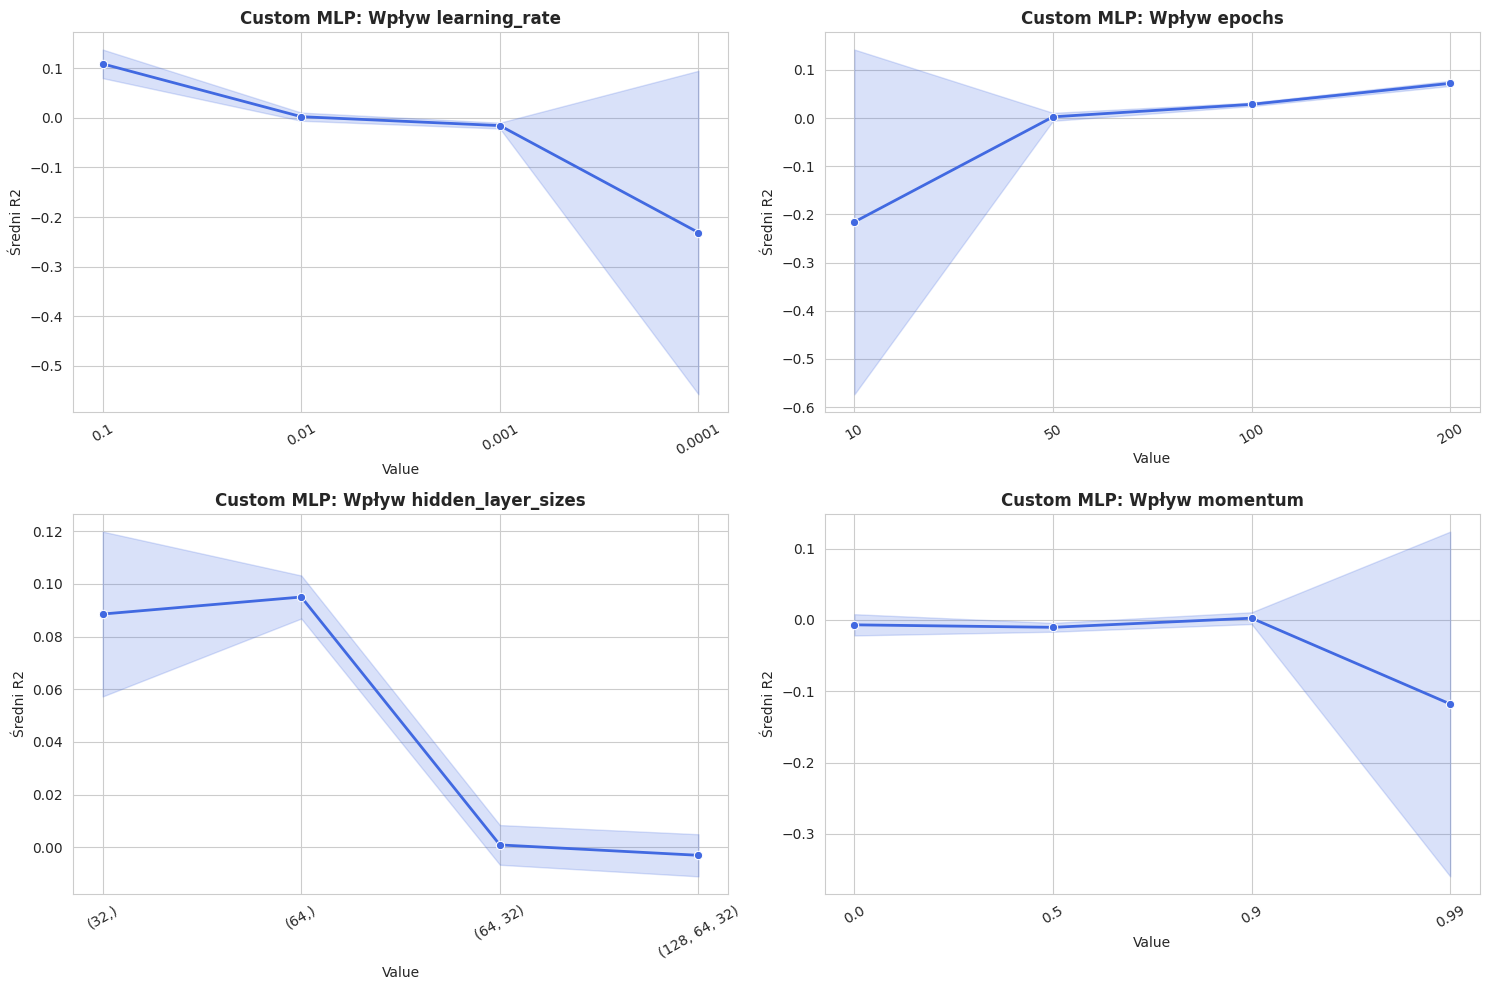

/tmp/ipython-input-1591830647.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=comparison_df, x='Model', y='R2 Score', palette='viridis')


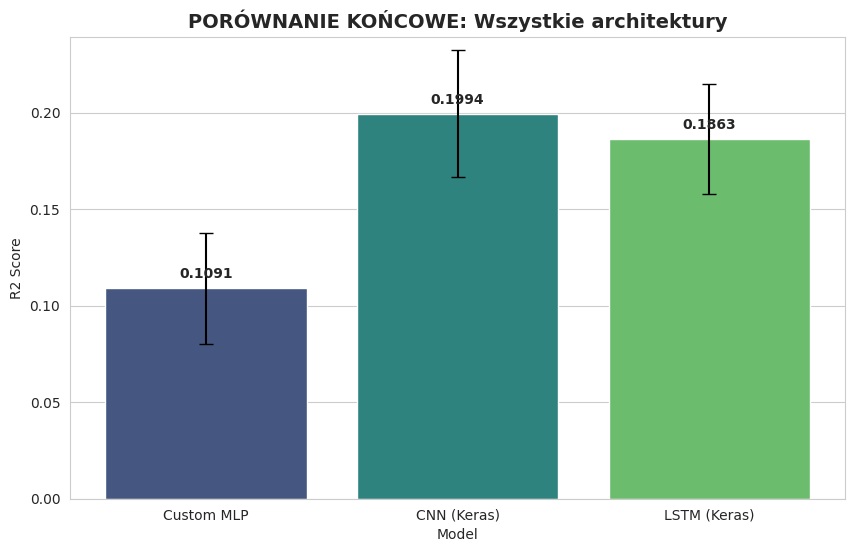

In [12]:
# @title Benchmarking - Pełne Porównanie (Custom MLP vs CNN vs LSTM)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. EKSTRAKCJA I ANALIZA NAJLEPSZYCH WYNIKÓW ---

# Podział wyników na poszczególne typy modeli
cnn_results = results_df[results_df['Parameter'].str.contains('CNN', na=False)].copy()
lstm_results = results_df[results_df['Parameter'].str.contains('LSTM', na=False)].copy()

custom_params_list = ["learning_rate", "epochs", "hidden_layer_sizes", "momentum"]
custom_mlp_results = results_df[results_df['Parameter'].isin(custom_params_list)].copy()

# Znalezienie absolutnie najlepszych konfiguracji dla każdego modelu
best_cnn = cnn_results.loc[cnn_results['Avg_R2'].idxmax()]
best_lstm = lstm_results.loc[lstm_results['Avg_R2'].idxmax()]
best_custom = custom_mlp_results.loc[custom_mlp_results['Avg_R2'].idxmax()]

# --- 2. GENEROWANIE RAPORTU TEKSTOWEGO ---

print("="*60)
print("BEST LIBRARY MODELS (KERAS - CNN & LSTM)")
print("="*60)
# Wybieramy lepszy z dwóch modeli bibliotecznych do nagłówka
top_keras = best_cnn if best_cnn['Avg_R2'] > best_lstm['Avg_R2'] else best_lstm
print(f"Overall Best Keras R2: {top_keras['Avg_R2']:.4f}")

print("\nOptimal Hyperparameters:")
print(f" ➔ CNN Best LR:  {best_cnn['Value']}")
print(f" ➔ LSTM Best LR: {best_lstm['Value']}")
print(f" ➔ Winner:       {'CNN' if best_cnn['Avg_R2'] > best_lstm['Avg_R2'] else 'LSTM'}")

print("\n" + "="*60)
print("BEST CUSTOM MODEL (NUMPY)")
print("="*60)
print(f"Best Avg R2 Score: {best_custom['Avg_R2']:.4f}")

print("\nOptimal Hyperparameters (Based on Study):")
# Wyświetlamy parametry z najlepszego przebiegu Custom MLP
print(f" ➔ Most Impactful Param: {best_custom['Parameter']}")
print(f" ➔ Best Found Value:     {best_custom['Value']}")
print(f" ➔ Performance Stability: +/- {best_custom['Std_R2']:.5f}")
print("="*60)

# --- 3. WIZUALIZACJA WYNIKÓW ---

# A. Wykresy wpływu parametrów dla Custom MLP (2x2)
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for i, param in enumerate(custom_params_list, 1):
    plt.subplot(2, 2, i)
    df_subset = custom_mlp_results[custom_mlp_results['Parameter'] == param]

    sns.lineplot(data=df_subset, x='Value', y='Avg_R2', marker='o', color='royalblue', linewidth=2)
    plt.fill_between(df_subset['Value'].astype(str),
                     df_subset['Avg_R2'] - df_subset['Std_R2'],
                     df_subset['Avg_R2'] + df_subset['Std_R2'],
                     alpha=0.2, color='royalblue')

    plt.title(f'Custom MLP: Wpływ {param}', fontweight='bold')
    plt.xticks(rotation=30)
    plt.ylabel('Średni R2')

plt.tight_layout()
plt.show()

# B. Bezpośrednie porównanie wszystkich modeli (Bar Chart)
plt.figure(figsize=(10, 6))
comparison_df = pd.DataFrame({
    'Model': ['Custom MLP', 'CNN (Keras)', 'LSTM (Keras)'],
    'R2 Score': [best_custom['Avg_R2'], best_cnn['Avg_R2'], best_lstm['Avg_R2']],
    'Error': [best_custom['Std_R2'], best_cnn['Std_R2'], best_lstm['Std_R2']]
})

ax = sns.barplot(data=comparison_df, x='Model', y='R2 Score', palette='viridis')
plt.errorbar(x=range(3), y=comparison_df['R2 Score'], yerr=comparison_df['Error'], fmt='none', c='black', capsize=5)

plt.title('PORÓWNANIE KOŃCOWE: Wszystkie architektury', fontsize=14, fontweight='bold')
plt.ylim(0, max(comparison_df['R2 Score']) * 1.2) # Skalowanie dla czytelności

# Dodanie etykiet nad słupkami
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.show()

Model CNN zwyciężył z wynikiem R2 0.1994 (LR=0.0001), pokonując model LSTM (0.1863) oraz najlepszą konfigurację Custom MLP (0.1091). W modelu własnym kluczowy okazał się learning_rate 0.1, podczas gdy niższe parametry powodowały niestabilność i ujemne wyniki. Najlepszą strukturą dla Custom MLP było (64,), a wydajność modelu systematycznie rosła wraz ze zwiększaniem liczby epok do 200. Wyraźna przewaga architektur Keras nad NumPy (o ok. 9 punktów) potwierdza ich wyższą skuteczność w modelowaniu złożonych zależności regresyjnych.